In [28]:
# https://mipt-stats.gitlab.io/courses/ad_fivt/linreg_sklearn.html

import numpy as np
import pandas as pd
import sklearn
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

# обратите внимание, что Scikit-Learn импортируется как sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [29]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/insurance_miptstats.csv', parse_dates=[0])
data.head()

,birthday,sex,bmi,children,smoker,region,charges
0,2001-12-20,female,27.900,0,yes,southwest,16884.92400
1,2003-03-18,male,33.770,1,no,southeast,1725.55230
2,1992-11-02,male,33.000,3,no,southeast,4449.46200
3,1987-07-27,male,22.705,0,no,northwest,21984.47061
4,1988-11-04,male,28.880,0,no,northwest,3866.85520


In [30]:
data.shape

(1338, 7)

In [32]:
train, test = train_test_split(data, test_size=0.2)
train.shape, test.shape

((1070, 7), (268, 7))

In [33]:
train['age'] = (pd.Timestamp('2021-04-17') - train['birthday']) / pd.Timedelta('1Y')

<ipython-input-33-38fb75301bc2>:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  train['age'] = (pd.Timestamp('2021-04-17') - train['birthday']) / pd.Timedelta('1Y')


In [34]:
categorial_features = ['sex', 'smoker', 'region']  # категориальные признаки
real_features = ['age', 'bmi', 'children']  # вещественные признаки
target_feature = 'charges'  # целевой признак

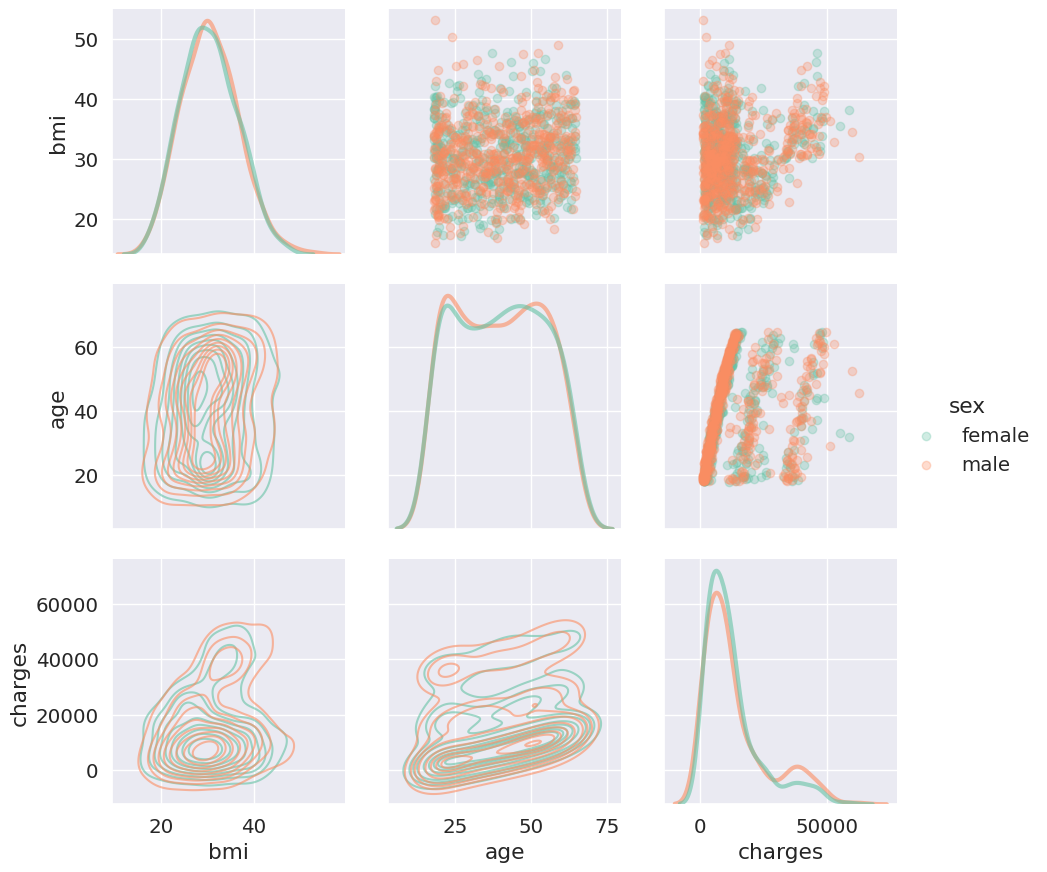

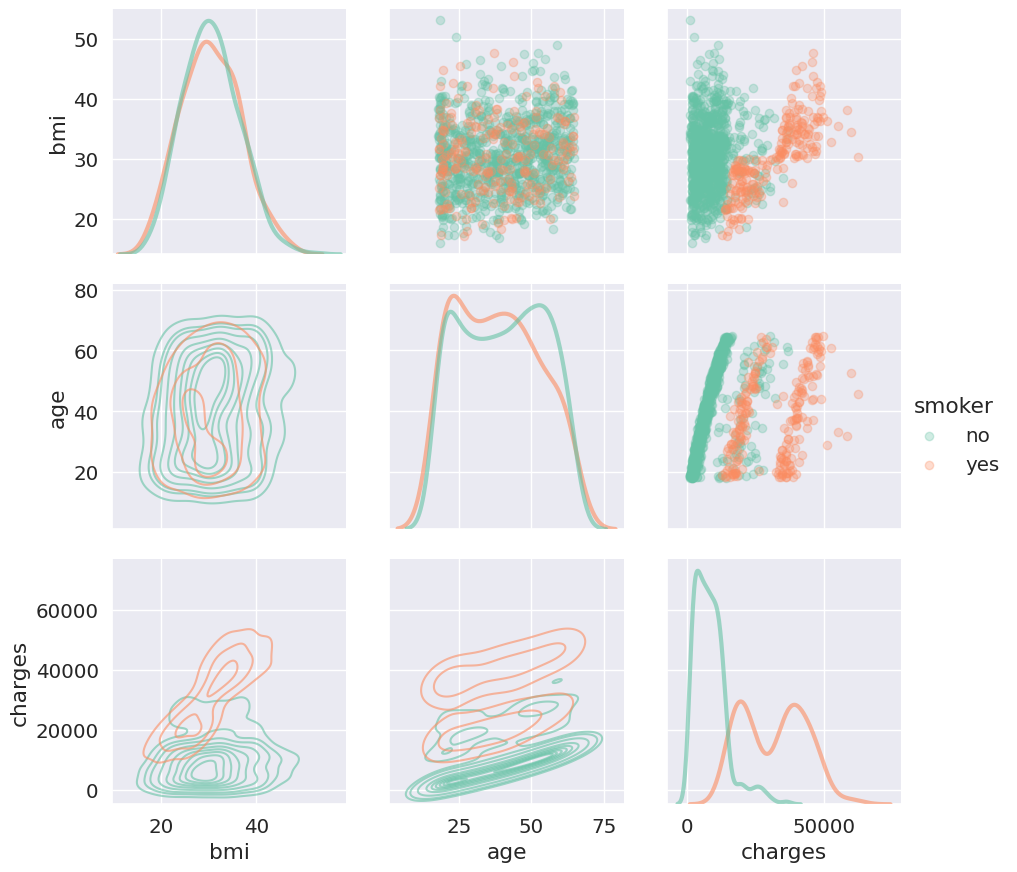

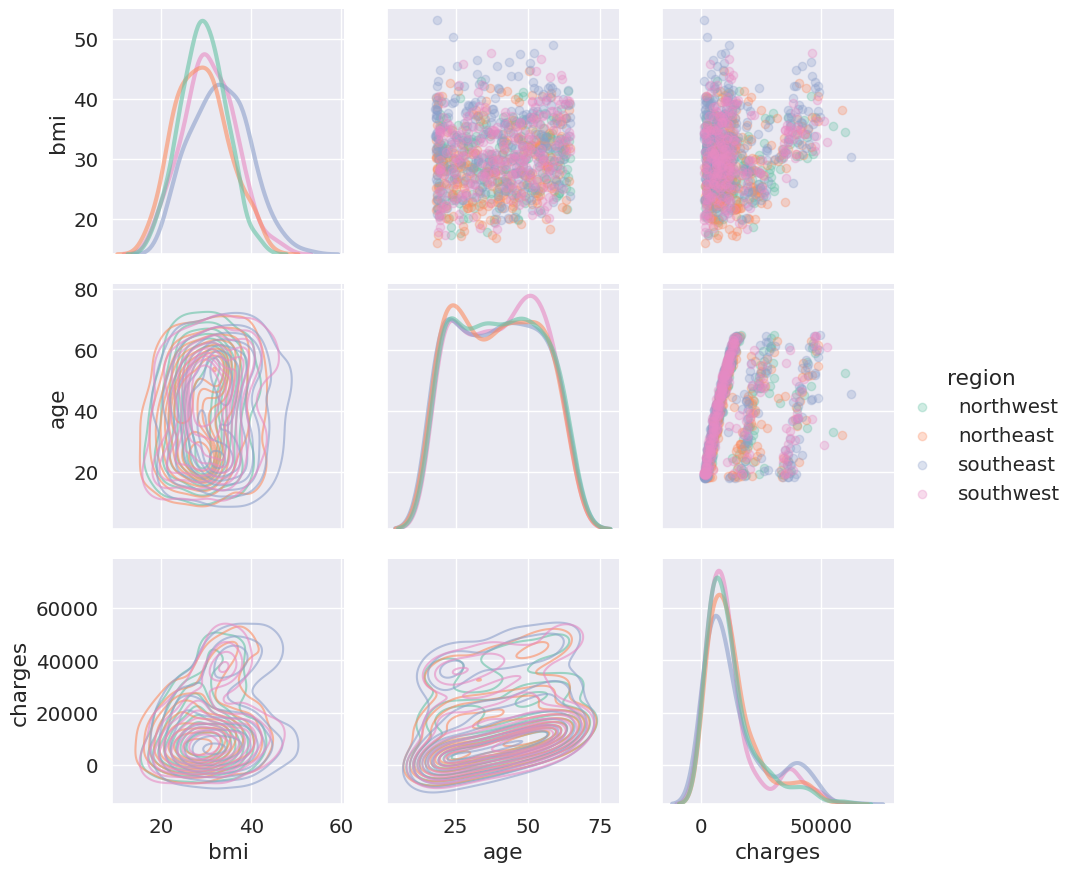

In [35]:
for hue in categorial_features:
    g = sns.PairGrid(train[['bmi', 'age', 'charges', hue]],
                     hue=hue, diag_sharey=False, height=3)

    g.map_lower(sns.kdeplot, alpha=0.6)
    g.map_upper(plt.scatter, alpha=0.3)
    g.map_diag(sns.kdeplot, lw=3, alpha=0.6,
               common_norm=False)  # каждая плотность по отдельности должна давать 1 при интегрировании

    g.add_legend()

In [36]:
encoder = OneHotEncoder(drop='first', sparse=False)  # объявляем модель
train_cat = encoder.fit_transform(train[categorial_features])  # обучаем и кодируем
train_cat

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1.]])

In [37]:
encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [39]:
X_train = np.hstack([train[real_features], train_cat])
X_train.shape

(1070, 8)

In [40]:
model = LinearRegression(fit_intercept=True)  # объявляем модель
model.fit(X_train, train[target_feature])  # обучаем

LinearRegression()

In [41]:
model.coef_

array([  257.31438772,   336.56325568,   423.94099187,   -25.48434935,
       23656.64811639,  -370.88646373,  -659.67773002,  -818.2905385 ])

In [42]:
model.intercept_

-12050.824412768286

In [43]:
# Получаем возраст клиента по дате рождения
test['age'] = (pd.Timestamp('2021-04-17') - test['birthday']) / pd.Timedelta('1Y')

# Кодируем категориальные признаки с помощью метода transform обученного ранее кодировщика
test_cat = encoder.transform(test[categorial_features])

# Соединяем данные
X_test = np.hstack([test[real_features], test_cat])

<ipython-input-43-58a9e1b0c46c>:2: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  test['age'] = (pd.Timestamp('2021-04-17') - test['birthday']) / pd.Timedelta('1Y')


In [44]:
test_preds = model.predict(X_test)

In [45]:
np.sqrt(((test[target_feature] - test_preds) ** 2).mean())

5793.112670753037

In [46]:
metrics.mean_squared_error(test[target_feature], test_preds) ** 0.5

5793.112670753037

In [47]:
metrics.mean_absolute_error(test[target_feature], test_preds)

4180.120715743261

In [48]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()

In [49]:
mean_absolute_percentage_error(test[target_feature], test_preds)

46.870457081881845

In [50]:
train_preds = model.predict(X_train)

metrics.mean_squared_error(train[target_feature], train_preds) ** 0.5, \
metrics.mean_absolute_error(train[target_feature], train_preds), \
mean_absolute_percentage_error(train[target_feature], train_preds)

(6105.021536747377, 4208.139727303212, 42.20707772888419)